In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy as sp


# read data
df = pd.read_csv('retail_price.csv')
index = ['product_category_name', 'product_id']
column_min = ['unit_price', 'product_score', 'freight_price', 'product_weight_g', 'comp_1', 'ps1', 'comp_2', 'ps2', 'comp_3', 'ps3']
# column_max = []
column_sum = ['customers']

product_category = ['bed_bath_table', 'computers_accessories', 'consoles_games', 'cool_stuff', 'furniture_decor']
#product_category = ['computers_accessories']
                    #,
                    #'garden_tools', 'health_beauty', 'perfumery', 'watches_gifts']

table_min = pd.pivot_table(df, values=column_min, index=index,  aggfunc=np.min)
# table_min = pivot_table(df, values='D', index=index,  aggfunc=np.max)
table_sum = pd.pivot_table(df, values=column_sum, index=index, aggfunc=np.sum)

In [27]:
table = table_min.merge(table_sum, on=index,how='left')
table

comp_1      comp_2      comp_3   
product_category_name product_id                                       
bed_bath_table        bed1         74.000000   39.240000   39.240000  \
                      bed2         74.000000   74.000000   39.240000   
                      bed3         74.000000   84.900000   39.240000   
                      bed4         77.933333   44.154444   39.990000   
                      bed5         89.900000  163.398710   45.950000   
computers_accessories computers1   94.900000   94.900000   77.900000   
                      computers2  114.491154  109.900000   77.900000   
                      computers3  139.990000  134.900000   78.712281   
                      computers4  114.491154  139.990000   77.900000   
                      computers5  114.491154  119.900000   77.900000   
                      computers6  114.491154  149.900000   77.900000   
consoles_games        consoles1    19.900000   19.900000   19.900000   
                      consoles2    19.900000   19.900000   19.900000   
cool_stuff            cool1        85.704286   85.704286   29.500000   
                      cool2        89.863333  116.927500   29.500000   
                      cool3        35.000000   29.500000   29.500000   
                      cool4        89.863333  116.927500   29.500000   
                      cool5        89.863333   99.990000   29.500000   
furniture_decor       furniture1   38.400000   35.000000   38.400000   
                      furniture2   69.900000   35.000000   75.000000   
                      furniture3   38.400000   35.000000   38.400000   
                      furniture4   69.900000   35.000000   78.535714   
garden_tools          garden1      49.900000   49.900000   49.900000   
                      garden10     49.900000   49.900000   49.900000   
                      garden2      49.900000   49.900000   49.900000   
                      garden3      49.900000   49.900000   49.900000   
                      garden4      49.900000   49.900000   49.900000   
                      garden5      49.900000   49.900000   49.900000   
                      garden6      49.900000   49.900000   49.900000   
                      garden7      49.900000   49.900000   49.900000   
                      garden8      49.900000   49.900000   49.900000   
                      garden9      49.900000   49.900000   49.900000   
health_beauty         health1      23.397407   79.990000   58.990000   
                      health10     23.990000   79.990000   58.990000   
                      health2      23.397407   79.990000   58.990000   
                      health3      23.990000   79.990000   58.990000   
                      health4      23.990000   79.990000   58.990000   
                      health5      19.990000   79.990000   58.799524   
                      health6      23.990000   79.990000   58.990000   
                      health7      19.990000   64.990000   58.799524   
                      health8      19.990000   79.990000   58.799524   
                      health9      19.990000   19.990000   58.799524   
perfumery             perfumery1   49.990000   56.990000   49.990000   
                      perfumery2   49.990000  116.906667  116.906667   
watches_gifts         watches1    103.792523  105.000000  132.531250   
                      watches2    103.792523  105.000000  132.531250   
                      watches3     78.000000   78.000000  132.531250   
                      watches4    103.792523  105.000000  132.531250   
                      watches5    103.792523  105.000000  132.531250   
                      watches6    103.792523  105.000000  132.531250   
                      watches7    103.792523  105.000000  132.531250   
                      watches8    103.792523  105.000000  132.531250   

                                  freight_price  product_score   
product_category_name product_id                                 
bed_bath_table   

## data / parameters

In [28]:
# Selling & Buying & Rating & Probability of buying
selling = {}
for category in product_category:
    selling[category] = (table.loc[category]['unit_price'].values)

buying = {}
for category in product_category:
    buying[category] = selling[category] * np.random.uniform(0.6,0.7)


rating = {}
for category in product_category:
    rating[category] = (table.loc[category]['product_score'].values)
MAX_RATING = 5.

# Customers
n_customers = {}
for category in product_category:
    n_customers[category] = (table.loc[category]['customers'].sum())

#assume rating is independent from the price
p2={}
for category in product_category:
    p2[category] = (np.exp(-selling[category]*(MAX_RATING - rating[category]) / 100) 
              / np.sum(np.exp(-selling[category]*(MAX_RATING - rating[category])/100)))


In [ ]:


# what % of 'market' customers do we get for each % of discount?




## model

In [29]:
def optimize_with_discount_factor(DISCOUNT_FACTOR, BUDGET):
    # fixed freight cost, can change if needed
    SHIPPING_COST = 5

    # how many customers we have that won't buy unless extra conditions are fufilled
    MARKET_CUSTOMERS = {category: 10000 for category in product_category}
    
    # what % of 'market' customers do we get if we have free shipping
    FREE_SHIPPING_FACTOR = 0

    # the budget
    #BUDGET = 1e9

    # inventory for each category
    INVENTORY_SPACE = 1e7
    
    m = gp.Model()

    BIGNUM = 1e6 # sum(n_customers.values())

    # decision variables
    stock = {}
    is_chosen = {}
    sold = {}
    discount = {}
    free_shipping = {}

    # initialising decision variables
    for category in product_category:
        I = range(len(selling[category]))
        stock[category] = m.addVars(I,vtype = GRB.INTEGER)
        is_chosen[category] = m.addVars(I, vtype = GRB.BINARY)
        sold[category] = m.addVars(I,vtype = GRB.INTEGER)
        discount[category] = m.addVars(I,vtype=GRB.CONTINUOUS, lb=0.1, ub=1)
        free_shipping[category] = m.addVars(I,  vtype = GRB.BINARY)


    # amount sold and extra customers
    captured_customers = lambda category,i: (
        MARKET_CUSTOMERS[category] * (FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                      + DISCOUNT_FACTOR * discount[category][i])
    )
    amount_sold  = lambda category,i: p2[category][i]* (n_customers[category] + captured_customers(category,i))

    # objective function
    m.setObjective(
        gp.quicksum(gp.quicksum(sold[category][i] * selling[category][i] * (1 - discount[category][i]) 
                                - stock[category][i] * buying[category][i]
                                - sold[category][i] * SHIPPING_COST * free_shipping[category][i]
                    for i in range(len(selling[category]))) for category in product_category),
        GRB.MAXIMIZE
    )

    # Can't store past inventory space
    m.addConstrs( gp.quicksum(stock[category][i] for i in range(len(selling[category]))) <= INVENTORY_SPACE 
                 for category in product_category)

    # Can't buy more than the budget
    m.addConstr(gp.quicksum( gp.quicksum(stock[category][i] * buying[category][i] for i in range(len(selling[category]))) 
                            for category in product_category) <= BUDGET)

    for category in product_category:
        # If a product is stocked, is_chosen is set to be 1 [Change to BIGNUM to remove dependencies on n_customers]
        m.addConstrs(stock[category][i] <= is_chosen[category][i] * BIGNUM
                     for i in range(len(selling[category])))
        # Can't sell more than you have stocked
        m.addConstrs(sold[category][i] <= stock[category][i] for i in range(len(selling[category])))
        # How much we can sell depends on number of customers [Removed is_chosen]
        m.addConstrs(sold[category][i] <= amount_sold(category, i)
                     for i in range(len(selling[category])))
        m.addConstrs((FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                      + DISCOUNT_FACTOR * discount[category][i]) <= 1 for i in range(len(selling[category])))

    m.params.NonConvex = 2
    m.optimize()
    
    
    obj_val = m.objVal

    # get the values of the discount decision variables
    discount_vals = {}
    for category in product_category:
        discount_vals[category] = [discount[category][i].X for i in range(len(selling[category]))]
        
    #get the vlues for stock
    stocks = {}
    for category in product_category:
        stocks[category] = [int(stock[category][i].x) for i in range(len(selling[category]))]

    # create a dictionary that stores the results
    results = {
        "objective_value": obj_val,
        #"budget": BUDGET,
        #"discount_factor": DISCOUNT_FACTOR,
        "discount_values": discount_vals,
        "stock": stocks
    }

    return results

In [30]:
# create a list of discount factors to study
Budget = np.arange(1e5, 1e9, 5e7).tolist()
#Budget = [1e5,1.5e5, 1e6,1.5e6, 1e7,1.5e7, 1e8,1.5e8, 1e9]

# create a dictionary to store the results
results_dict1 = {}

# optimize for each discount factor and store the results
for budget in Budget:
    results = optimize_with_discount_factor(5, budget)
    results_dict1[budget] = results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-19
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 198 nonzeros
Model fingerprint: 0x01ccdd8a
Model has 44 quadratic objective terms
Variable types: 22 continuous, 88 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+01, 2e+02]
  QObjective range [1e+01, 3e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 1e+07]
Found heuristic solution: objective -0.0000000
Presolve removed 75 rows and 70 columns
Presolve time: 0.15s
Presolved: 56 rows, 59 columns, 167 nonzeros
Presolved model has 18 bilinear constraint(s)
Variable types: 37 continuous, 22 integer (0 binary)
Found heuristic solution:


Cutting planes:
  RLT: 2

Explored 3 nodes (12 simplex iterations) in 0.41 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 7: 756135 756128 756082 ... -0

Optimal solution found (tolerance 1.00e-04)
Best objective 7.561345058035e+05, best bound 7.561867420682e+05, gap 0.0069%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 198 nonzeros
Model fingerprint: 0xfba8e38f
Model has 44 quadratic objective terms
Variable types: 22 continuous, 88 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+01, 2e+02]
  QObjective range [1e+01, 3e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 2e+08]
Found heuristic solution: objective -0.0000000
Pr

H    0     0                    755324.68164 760432.336  0.68%     -    0s
     0     0 757356.281    0    2 755324.682 757356.281  0.27%     -    0s
H    0     0                    756081.71164 757356.281  0.17%     -    0s
     0     0 756346.232    0    2 756081.712 756346.232  0.03%     -    0s
     0     0 756214.238    0    2 756081.712 756214.238  0.02%     -    0s
H    0     0                    756127.55625 756214.238  0.01%     -    0s
H    0     0                    756134.50580 756214.238  0.01%     -    0s
     0     2 756214.238    0    2 756134.506 756214.238  0.01%     -    0s

Cutting planes:
  RLT: 2

Explored 3 nodes (12 simplex iterations) in 0.36 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 7: 756135 756128 756082 ... -0

Optimal solution found (tolerance 1.00e-04)
Best objective 7.561345058035e+05, best bound 7.561867420682e+05, gap 0.0069%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1r

Presolve removed 93 rows and 108 columns
Presolve time: 0.26s
Presolved: 3 rows, 3 columns, 7 nonzeros
Presolved model has 1 bilinear constraint(s)
Found heuristic solution: objective 713398.76812
Variable types: 2 continuous, 1 integer (0 binary)
Found heuristic solution: objective 713419.47295

Root relaxation: objective 7.604323e+05, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 760432.336    0    2 713419.473 760432.336  6.59%     -    0s
H    0     0                    755324.68164 760432.336  0.68%     -    0s
     0     0 757356.281    0    2 755324.682 757356.281  0.27%     -    0s
H    0     0                    756081.71164 757356.281  0.17%     -    0s
     0     0 756346.232    0    2 756081.712 756346.232  0.03%     -    0s
     0     0 756214.238    0    2 756081.712 756214.238  0.02%     -    0s
H    0     0  


CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 198 nonzeros
Model fingerprint: 0x9286fd7d
Model has 44 quadratic objective terms
Variable types: 22 continuous, 88 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+01, 2e+02]
  QObjective range [1e+01, 3e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 8e+08]
Found heuristic solution: objective -0.0000000
Presolve removed 93 rows and 108 columns
Presolve time: 0.23s
Presolved: 3 rows, 3 columns, 7 nonzeros
Presolved model has 1 bilinear constraint(s)
Found heuristic solution: objective 713398.76812
Variable types: 2 continuous, 1 integer (0 binary)
Found heuristic solution: objective 713419.47295

Root relaxation: objective 7.604323e+05, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current No

H    0     0                    756127.55625 756214.238  0.01%     -    0s
H    0     0                    756134.50580 756214.238  0.01%     -    0s
     0     2 756214.238    0    2 756134.506 756214.238  0.01%     -    0s

Cutting planes:
  RLT: 2

Explored 3 nodes (12 simplex iterations) in 0.31 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 7: 756135 756128 756082 ... -0

Optimal solution found (tolerance 1.00e-04)
Best objective 7.561345058035e+05, best bound 7.561867420682e+05, gap 0.0069%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 198 nonzeros
Model fingerprint: 0x0d78d860
Model has 44 quadratic objective terms
Variable types: 22 continuous, 88 integer (44 binary)
Coefficient statis

In [31]:
# create a list of discount factors to study
#Budget = np.arange(1e5, 1e9, 1e2).tolist()
budget = 1e9
discount_factors = np.arange(1, 7, 0.5).tolist()

# create a dictionary to store the results
results_dict = {}

# optimize for each discount factor and store the results
for discount_factor in discount_factors:
    results = optimize_with_discount_factor(discount_factor, budget)
    results_dict[discount_factor] = results

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 198 nonzeros
Model fingerprint: 0x6cd08c48
Model has 44 quadratic objective terms
Variable types: 22 continuous, 88 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+01, 2e+02]
  QObjective range [1e+01, 3e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 1e+09]
Found heuristic solution: objective -0.0000000
Presolve removed 93 rows and 108 columns
Presolve time: 0.31s
Presolved: 3 rows, 3 columns, 7 nonzeros
Presolved model has 1 bilinear constraint(s)
Found heuristic solution: objective 350165.75790
Variable types: 2 continuous, 1 integer (0 binary)
Found heuristic solution: objective 350186.46273

Root relaxation: object

     0     0 458412.567    0    2 456264.743 458412.567  0.47%     -    0s
     0     0 458412.235    0    2 456264.743 458412.235  0.47%     -    0s
     0     0 458412.069    0    2 456264.743 458412.069  0.47%     -    0s
H    0     0                    456539.64320 458412.069  0.41%     -    0s
     0     2 458412.069    0    2 456539.643 458412.069  0.41%     -    0s

Cutting planes:
  RLT: 2

Explored 19 nodes (19 simplex iterations) in 0.48 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 6: 456540 456265 449072 ... -0

Optimal solution found (tolerance 1.00e-04)
Best objective 4.565396432043e+05, best bound 4.565685210735e+05, gap 0.0063%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 198

Presolved: 3 rows, 3 columns, 7 nonzeros
Presolved model has 1 bilinear constraint(s)
Found heuristic solution: objective 615716.30916
Variable types: 2 continuous, 1 integer (0 binary)
Found heuristic solution: objective 615737.01400

Root relaxation: objective 6.602064e+05, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 660206.354    0    2 615737.014 660206.354  7.22%     -    0s
H    0     0                    651984.52865 660206.354  1.26%     -    0s
     0     0 652158.690    0    2 651984.529 652158.690  0.03%     -    0s
     0     0 652078.162    0    2 651984.529 652078.162  0.01%     -    0s
     0     0 652037.898    0    2 651984.529 652037.898  0.01%     -    0s

Cutting planes:
  RLT: 3

Explored 1 nodes (7 simplex iterations) in 0.47 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

So

Presolve time: 0.30s
Presolved: 3 rows, 3 columns, 7 nonzeros
Presolved model has 1 bilinear constraint(s)
Found heuristic solution: objective 812380.40727
Variable types: 2 continuous, 1 integer (0 binary)
Found heuristic solution: objective 812401.11210

Root relaxation: objective 8.622660e+05, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 862265.963    0    2 812401.112 862265.963  6.14%     -    0s
H    0     0                    859201.78489 862265.963  0.36%     -    0s
     0     0 861926.162    0    2 859201.785 861926.162  0.32%     -    0s
H    0     0                    861146.08434 861926.162  0.09%     -    0s
     0     0 861756.261    0    2 861146.084 861756.261  0.07%     -    0s
H    0     0                    861554.07582 861756.261  0.02%     -    0s
H    0     0                    861565.55378 861756.261

In [32]:
objective = []
discount = []

for discount_factor in discount_factors:
    print( results_dict[discount_factor][ "objective_value"])
    
    print( results_dict[discount_factor]["discount_values"])
    
    objective.append( results_dict[discount_factor][ "objective_value"])
    discount.append(max(max(results_dict[discount_factor]["discount_values"].values())))
    
    print(discount)

368578.9300222239
{'bed_bath_table': [0.10010005916543917, 0.10016391703339576, 0.10025631521238249, 0.10015203573270418, 0.1], 'computers_accessories': [0.10005811637811064, 0.10000000000000016, 0.1, 0.1, 0.10000000000000017, 0.10028577764676218], 'consoles_games': [0.16020915076996925, 0.16019028629256696], 'cool_stuff': [0.10000920434907955, 0.10022674990070644, 0.10009943172558579, 0.10062905823916214, 0.1000000000000001], 'furniture_decor': [0.10027951744105532, 0.10009889932533701, 0.10000000000000012, 0.10049776730129414]}
[0.16020915076996925]
412212.3596526593
{'bed_bath_table': [0.10010265949036849, 0.10007807908251745, 0.10048314322894988, 0.10000991421533376, 0.10026470188541486], 'computers_accessories': [0.1, 0.10006658896529522, 0.1001356929958834, 0.10007071112710567, 0.10013513724049164, 0.10005637239194215], 'consoles_games': [0.16752744000656725, 0.1675395892060309], 'cool_stuff': [0.10019758642838948, 0.10012861495960317, 0.1, 0.10036489170602025, 0.1002048372389444

In [33]:
objective1 = []
discount1 = []
for budget in Budget:
    print("Objective vlaues", results_dict1[budget][ "objective_value"])
    
    print( results_dict1[budget]["discount_values"])
    
    objective1.append( results_dict1[budget][ "objective_value"])
    
    discount1.append(max(max(results_dict1[budget]["discount_values"].values())))
    


Objective vlaues 49141.53730810863
{'bed_bath_table': [0.1, 0.1, 0.1, 0.1, 0.1], 'computers_accessories': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'consoles_games': [0.1, 0.1], 'cool_stuff': [0.1, 0.1, 0.1, 0.1, 0.1], 'furniture_decor': [0.1, 0.1, 0.1, 0.1]}
Objective vlaues 756134.50580351
{'bed_bath_table': [0.16514039901478397, 0.16517153615938887, 0.16507066443126756, 0.16511740792663962, 0.1651879782767694], 'computers_accessories': [0.14510466448651263, 0.14510319373824404, 0.14508020339579103, 0.14511957448806584, 0.14512516102363263, 0.145192553791732], 'consoles_games': [0.17781188587991073, 0.17782861328488042], 'cool_stuff': [0.1361652157978117, 0.13617362684594356, 0.13613570865678218, 0.13608981437552636, 0.13611465841967038], 'furniture_decor': [0.15687573682979514, 0.15682334915369267, 0.1568578473182012, 0.1553063228262582]}
Objective vlaues 756134.50580351
{'bed_bath_table': [0.16514039901478397, 0.16517153615938887, 0.16507066443126756, 0.16511740792663962, 0.1651879782767694]

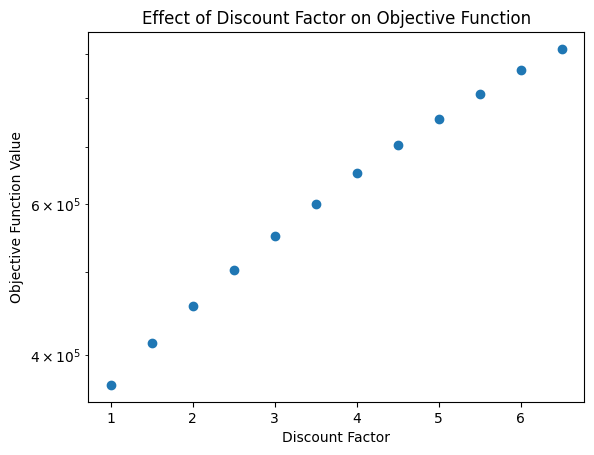

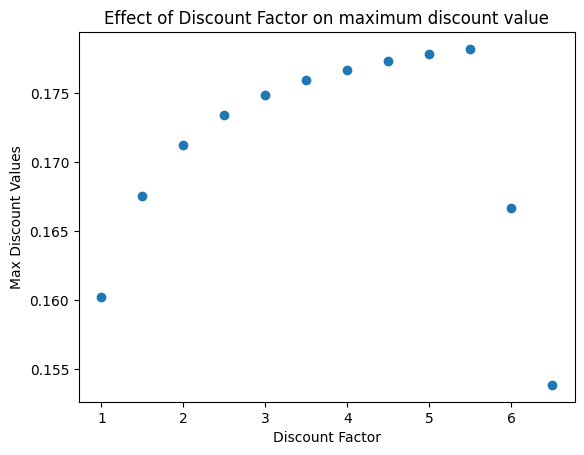

In [34]:
import matplotlib.pyplot as plt

# plot objective function values against discount factors
plt.scatter(discount_factors, objective)
plt.xlabel("Discount Factor")
plt.ylabel("Objective Function Value")
plt.title("Effect of Discount Factor on Objective Function")
plt.yscale('log')
plt.show()

plt.scatter(discount_factors, discount)
plt.xlabel("Discount Factor")
plt.ylabel("Max Discount Values")
plt.title("Effect of Discount Factor on maximum discount value")
plt.show()



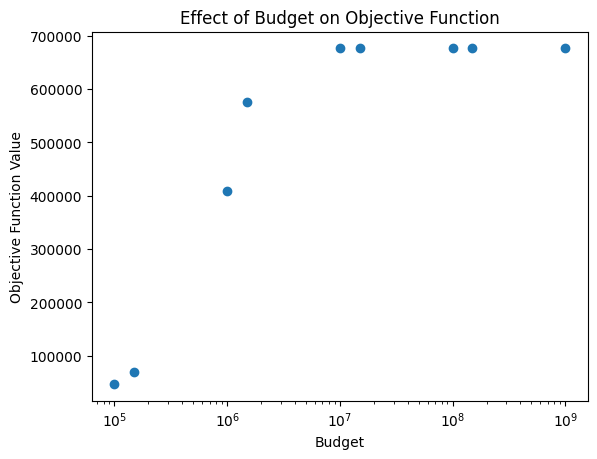

In [30]:
import matplotlib.pyplot as plt

# plot objective function values against discount factors
plt.scatter(Budget, objective1)
plt.xlabel("Budget")
plt.ylabel("Objective Function Value")
plt.title("Effect of Budget on Objective Function")

plt.xscale('log')
plt.show()

#plt.savefig('Effect of Budget on Objective Function.png')

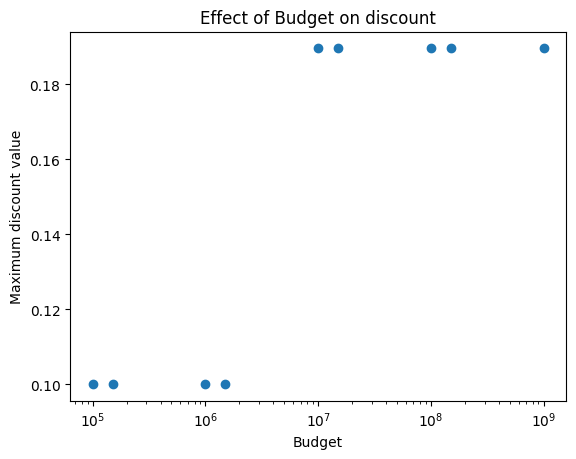

In [31]:
# plot objective function values against discount factors
plt.scatter(Budget, discount1)
plt.xlabel("Budget")
plt.ylabel("Maximum discount value")
plt.title("Effect of Budget on discount")
plt.xscale('log')
plt.show()

#plt.savefig('Effect of Budget on discount')

In [26]:
Budget

[100000.0,
 50100000.0,
 100100000.0,
 150100000.0,
 200100000.0,
 250100000.0,
 300100000.0,
 350100000.0,
 400100000.0,
 450100000.0,
 500100000.0,
 550100000.0,
 600100000.0,
 650100000.0,
 700100000.0,
 750100000.0,
 800100000.0,
 850100000.0,
 900100000.0,
 950100000.0]